In [1]:
import sys
#print(sys.executable)
print(sys.version)
#print(sys.version_info)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8705949657061650305, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4966593331
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4955660495105917989
 physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
import tensorflow as tf

In [3]:
from __future__ import print_function, division

#import tensorflowgpu
from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [4]:
device_name="/gpu:0"

In [5]:
def get_generator(input_layer):
    '''
    Requires the input layer as input, outputs the model and the final layer
    '''

    hid = Dense(128 * 16 * 16, activation='relu')(input_layer)    
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = Reshape((16, 16, 128))(hid)

    hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)    
    #hid = Dropout(0.5)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    #hid = Dropout(0.5)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
    out = Activation("tanh")(hid)

    model = Model(input_layer, out)
    model.summary()

    return model, out

In [6]:
def get_discriminator(input_layer):
    '''
    Requires the input layer as input, outputs the model and the final layer
    '''

    hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Flatten()(hid)
    hid = Dropout(0.4)(hid)
    out = Dense(1, activation='sigmoid')(hid)

    model = Model(input_layer, out)

    model.summary()

    return model, out

In [7]:
from keras.preprocessing import image
import PIL

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_imgs(batchidx):
    noise = generate_noise(9, 100)
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(3, 3)
    count = 0
    for i in range(3):
        for j in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[count], scale=True)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            count += 1
    plt.show()
    plt.close()

In [8]:
# GAN creation
img_input = Input(shape=(32,32,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

In [9]:
BATCH_SIZE = 16

# # Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()

# Select Cars
X_train = X_train[y_train[:,0]==1]
print ("Training shape: {}".format(X_train.shape))

# Normalize data
X_train = (X_train - 127.5) / 127.5
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

170500096/170498071 [==============================] - 24s 0us/step
Training shape: (5000, 32, 32, 3)


c:\users\rohit\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 1.2909440679165225, Discriminator Loss: [0.33330652 0.        ]


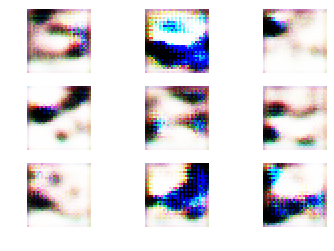

  Epoch: 2, Generator Loss: 1.1892966109877214, Discriminator Loss: [0.35509515 0.        ]


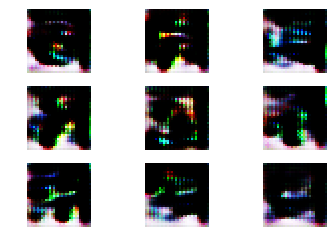

  Epoch: 3, Generator Loss: 1.2362091049599724, Discriminator Loss: [0.33895138 0.        ]


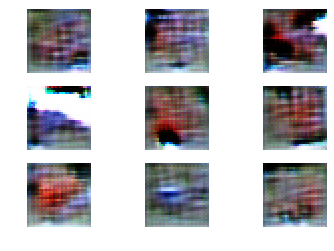

  Epoch: 4, Generator Loss: 0.9059952421304889, Discriminator Loss: [0.38801447 0.        ]


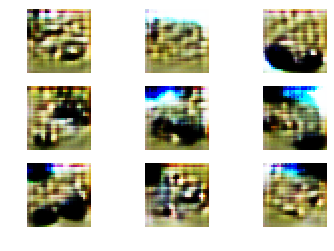

  Epoch: 5, Generator Loss: 0.9243018961666772, Discriminator Loss: [0.39926696 0.        ]


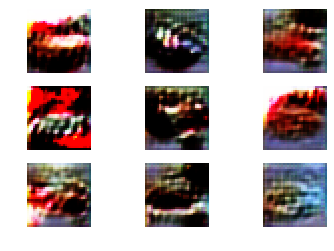

  Epoch: 6, Generator Loss: 1.1997247085822984, Discriminator Loss: [0.39586478 0.        ]


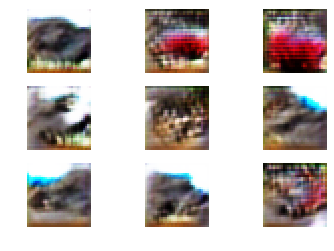

  Epoch: 7, Generator Loss: 1.405922916610367, Discriminator Loss: [0.4221005 0.       ]


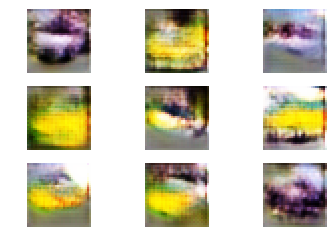

  Epoch: 8, Generator Loss: 1.3345641585257955, Discriminator Loss: [0.39837 0.     ]


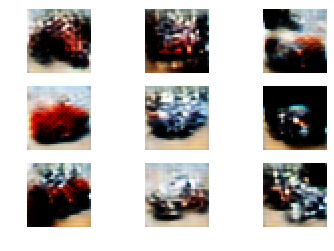

  Epoch: 9, Generator Loss: 1.3436090141707935, Discriminator Loss: [0.43395028 0.        ]


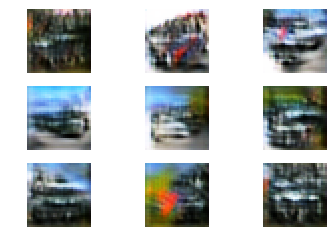

  Epoch: 10, Generator Loss: 1.363943820532698, Discriminator Loss: [0.5101186 0.       ]


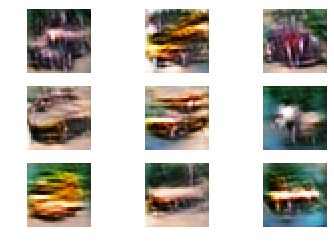

  Epoch: 11, Generator Loss: 1.2493739862424822, Discriminator Loss: [0.45680663 0.        ]


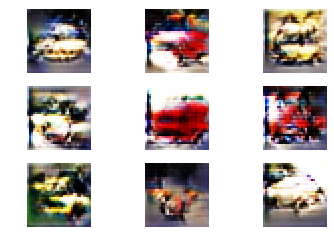

  Epoch: 12, Generator Loss: 1.3828249017779644, Discriminator Loss: [0.4719142 0.       ]


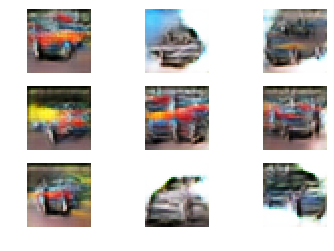

  Epoch: 13, Generator Loss: 1.2396424351594386, Discriminator Loss: [0.536862 0.      ]


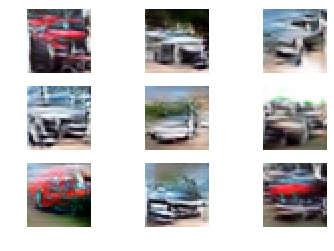

  Epoch: 14, Generator Loss: 1.1048418739452386, Discriminator Loss: [0.4894103 0.       ]


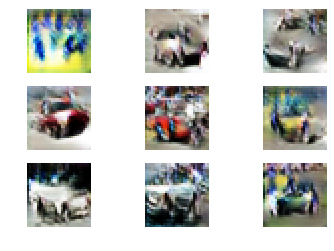

  Epoch: 15, Generator Loss: 0.989812807036707, Discriminator Loss: [0.514069 0.      ]


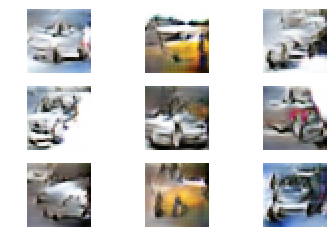

  Epoch: 16, Generator Loss: 0.9670822677704004, Discriminator Loss: [0.5585869 0.       ]


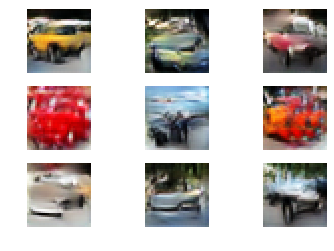

  Epoch: 17, Generator Loss: 0.9894951304229789, Discriminator Loss: [0.52335817 0.        ]


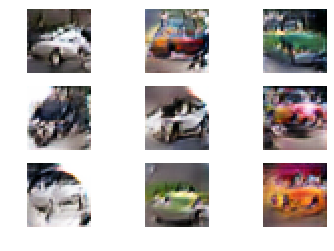

  Epoch: 18, Generator Loss: 1.0064125737079825, Discriminator Loss: [0.5096887 0.       ]


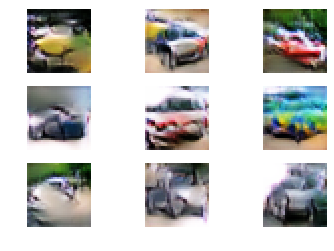

  Epoch: 19, Generator Loss: 1.0257416869012208, Discriminator Loss: [0.5131534 0.       ]


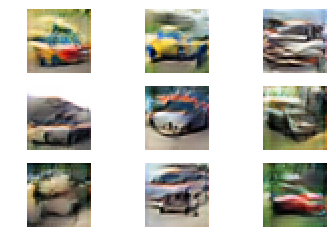

  Epoch: 20, Generator Loss: 1.116303435096947, Discriminator Loss: [0.48962432 0.        ]


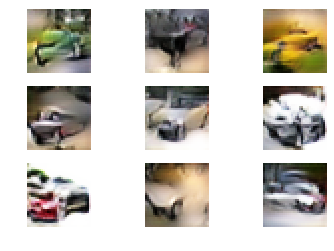

  Epoch: 21, Generator Loss: 1.1336785428321514, Discriminator Loss: [0.5012695 0.       ]


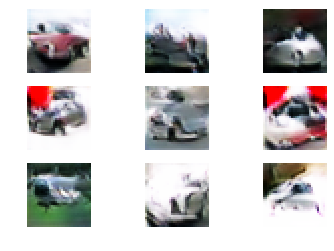

  Epoch: 22, Generator Loss: 1.130512995406603, Discriminator Loss: [0.50455046 0.        ]


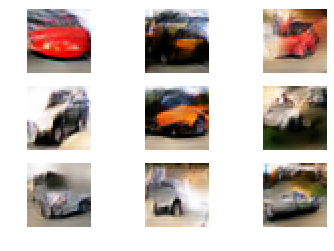

  Epoch: 23, Generator Loss: 1.2666347314340947, Discriminator Loss: [0.4283278 0.       ]


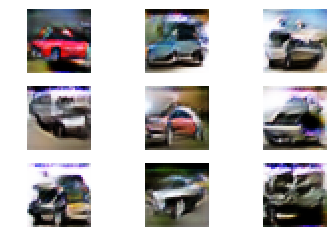

  Epoch: 24, Generator Loss: 1.1239741001373682, Discriminator Loss: [0.51562953 0.        ]


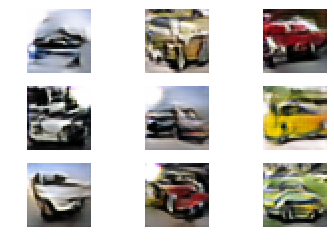

  Epoch: 25, Generator Loss: 1.1032430151334176, Discriminator Loss: [0.56823105 0.        ]


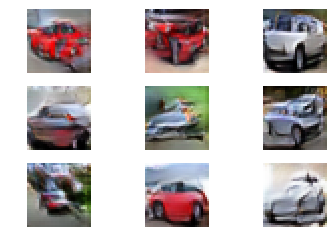

  Epoch: 26, Generator Loss: 0.9953843709559013, Discriminator Loss: [0.52665734 0.        ]


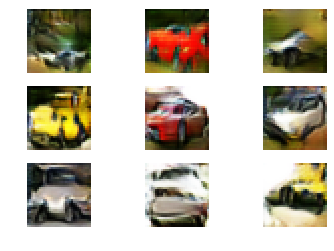

  Epoch: 27, Generator Loss: 0.9645652261873087, Discriminator Loss: [0.53809613 0.        ]


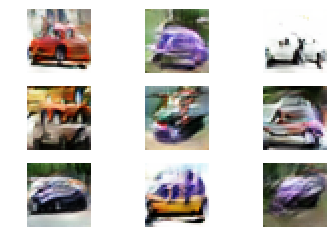

  Epoch: 28, Generator Loss: 1.0957329157644358, Discriminator Loss: [0.5548792 0.       ]


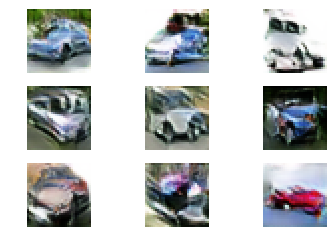

  Epoch: 29, Generator Loss: 1.0230598472631895, Discriminator Loss: [0.5363495 0.       ]


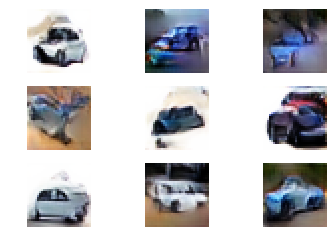

  Epoch: 30, Generator Loss: 1.0352362649849591, Discriminator Loss: [0.5355668 0.       ]


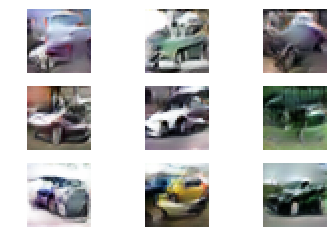

  Epoch: 31, Generator Loss: 1.07853410163751, Discriminator Loss: [0.52379227 0.        ]


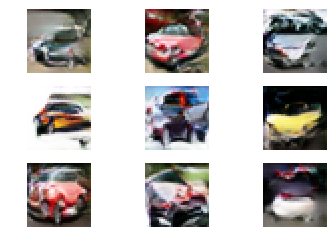

KeyboardInterrupt: 

In [10]:
N_EPOCHS = 100
for epoch in range(N_EPOCHS):

    cum_d_loss = 0.
    cum_g_loss = 0.

    for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
        images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

        noise_data = generate_noise(BATCH_SIZE, 100)
        generated_images = generator.predict(noise_data)

        # Train on soft labels (add noise to labels as well)
        noise_prop = 0.05 # Randomly flip 5% of labels

        # Prepare labels for real data
        true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
        true_labels[flipped_idx] = 1 - true_labels[flipped_idx]

        # Train discriminator on real data
        d_loss_true = discriminator.train_on_batch(images, true_labels)

        # Prepare labels for generated data
        gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
        gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]

        # Train discriminator on generated data
        d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

        d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
        cum_d_loss += d_loss

        # Train generator
        noise_data = generate_noise(BATCH_SIZE, 100)
        g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
        cum_g_loss += g_loss

    print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
    show_imgs("epoch" + str(epoch))
